# Global Carbon Dioxide Concentrations

# Introduction

Global warming is a pressing issue facing humanity today, with rippling implications for the environment, economy, and society. At the heart of this phenomenon lies the increase in greenhouse gasses, of which carbon dioxide (CO2) is a primary contributor (Lindsey, 2024). As a potent greenhouse gas, CO2 traps heat in the Earth's atmosphere, leading to the warming of the Earth. Of course, we need a certain amount of greenhouse gases in the atmosphere so that the Earth doesn't freeze, but a surplus of these gases can also have detrimental side-effects, such as sea-level rise and droughts (Means, 2023). Therefore, understanding the trends in atmospheric CO2 levels is crucial for evaluating the extent of human impact on the climate. In this study, we aim to explore how the annual levels of atmospheric CO2 have evolved over the past six decades, and evaluate the causal relation between CO2 and mean global surface temperature. Understanding these changes is vital for identifying drivers of CO2 levels and informing strategies for climate change mitigation.

To undergo this research, monthly atmospheric carbon dioxide concentrations from 1959 to 2024 were collected from the National Oceanic and Atmospheric Administration (NOAA) Global Monitoring Laboratory. The NOAA's extensive monitoring network provides rigorous and reliable data. The two datasets (one for CO2 and the other for surface temperature) provide a comprehensive record of their respective markers, with enough precision to obtain a high-quality analysis.

## Extracting & Plotting The Raw Data

In [72]:
# Libraries to be used
import csv
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import iirnotch, lfilter

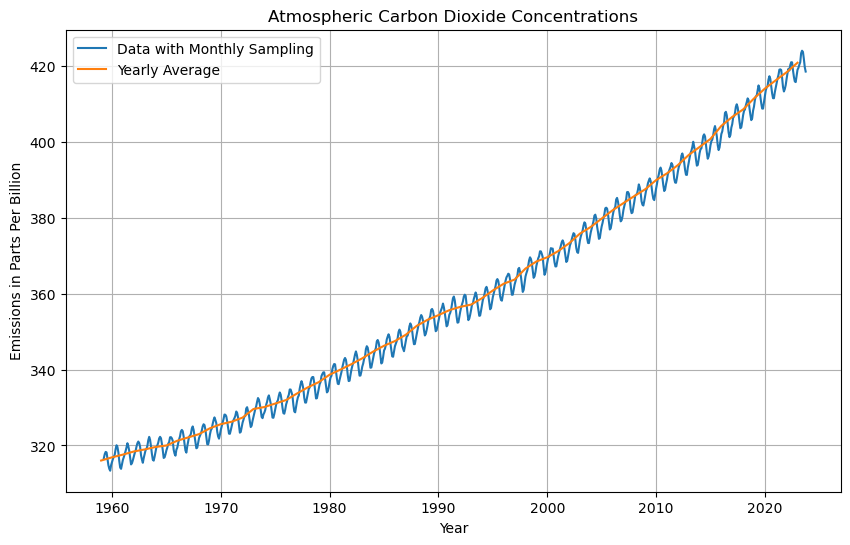

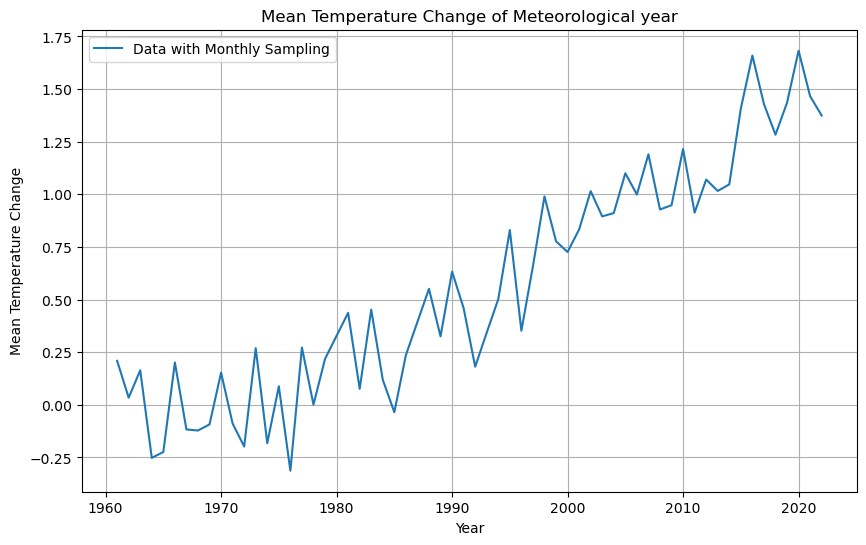

In [159]:
# Define a function to parse the date string into numerical values
def parse_date(date_str):
    year, month = date_str.split("M")
    return int(year) + int(month) / 12  # Convert month to fraction of a year

# Define a list to store the data
data = []

# Open the CSV file and read the data
with open('atmos_co.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header row
    for index, row in enumerate(reader):
        if index % 2 == 0:  # Check if the index is even
            numerical_date = parse_date(row[0])  # Parse the date string
            value = float(row[1])  # Convert the value to float
            data.append([numerical_date, value])

# Convert the data to a NumPy array for easier manipulation
data = np.array(data)

# Get the unique years from the data
unique_years = np.unique(data[:, 0].astype(int))

# Initialize a list to store the average CO2 concentration per year
avg_co2_per_year = []

# Calculate the average CO2 concentration for each year
for year in unique_years:
    mask = data[:, 0].astype(int) == year
    avg_co2 = np.mean(data[mask, 1])
    avg_co2_per_year.append([year, avg_co2])

years = [item[0] for item in data][0:775]
co2_values = [item[1] for item in data][0:775]
percentages = [item[1] for item in percent_vals][0:775]

avg_years = [item[0] for item in avg_co2_per_year][0:65]
avg_values = [item[1] for item in avg_co2_per_year][0:65] # excluding 2024 due to lack of data

years_temp, temp = np.loadtxt("surface_temp.csv", delimiter=",", skiprows=1, unpack=True)

plt.figure(figsize=(10, 6))
plt.title("Atmospheric Carbon Dioxide Concentrations")
plt.xlabel("Year")
plt.ylabel("Emissions in Parts Per Billion")
plt.plot(years, co2_values, label="Data with Monthly Sampling")
plt.plot(avg_years, avg_values, label="Yearly Average")
plt.grid(True)
plt.legend()

plt.figure(figsize=(10, 6))
plt.title("Mean Temperature Change of Meteorological year")
plt.xlabel("Year")
plt.ylabel("Mean Temperature Change")
plt.plot(years_temp, temp, label="Data with Monthly Sampling")
plt.grid(True)
plt.legend()

# Convert lists to NumPy arrays
avg_co2_per_year = np.array(avg_co2_per_year)
years_array = np.array(years)
co2_values_array = np.array(co2_values)
percentages_array = np.array(percentages)

# Results & Analysis

Line of Best Fit: y = 1.63993955337548x -2906.8046657085565


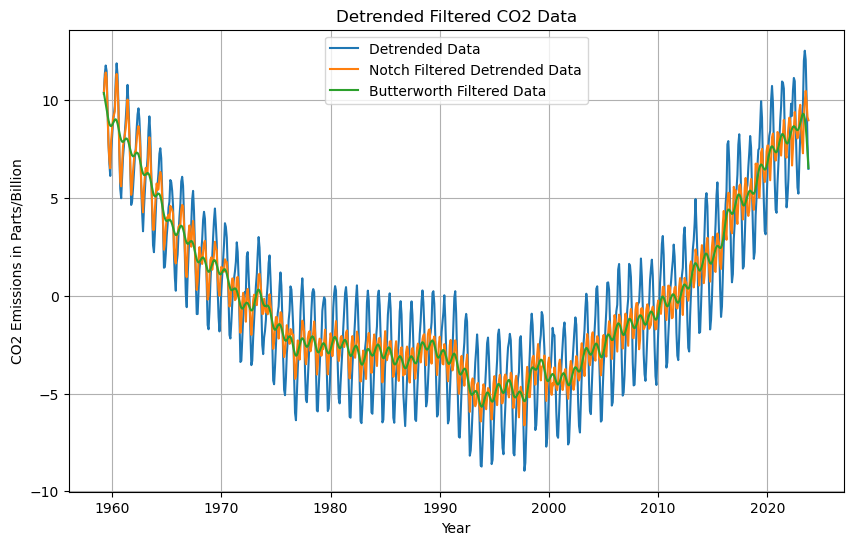

<Figure size 640x480 with 0 Axes>

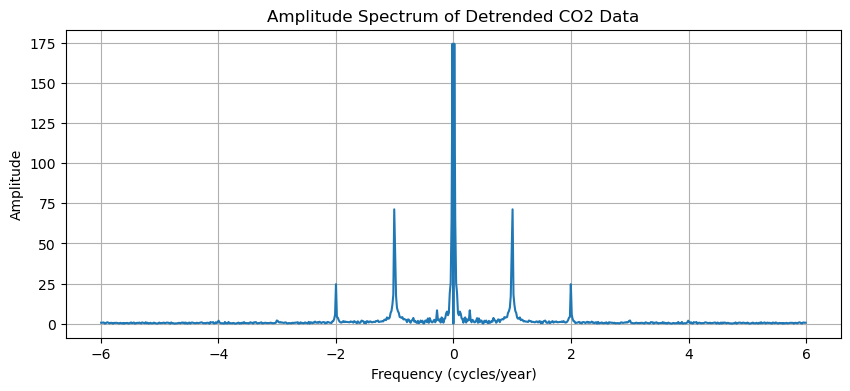

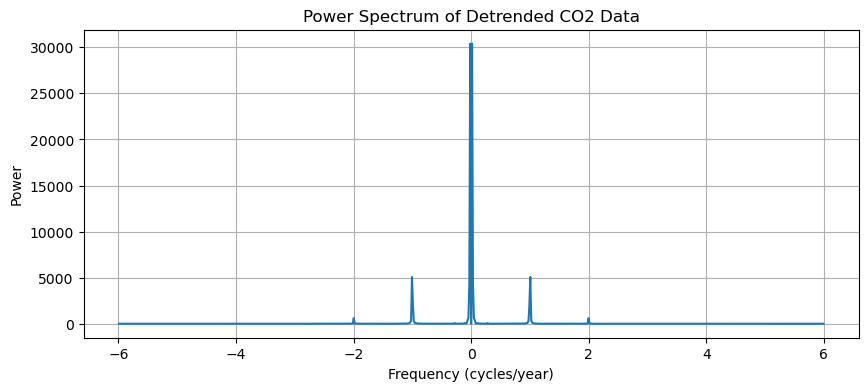

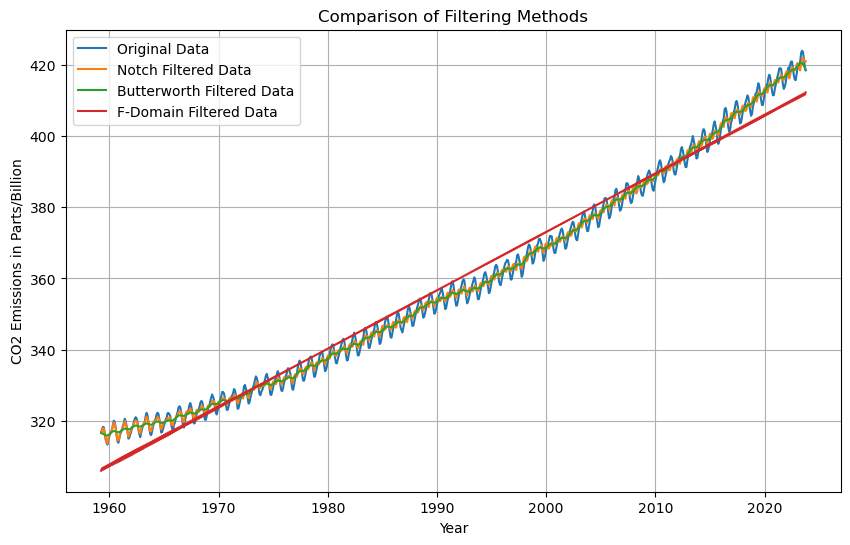

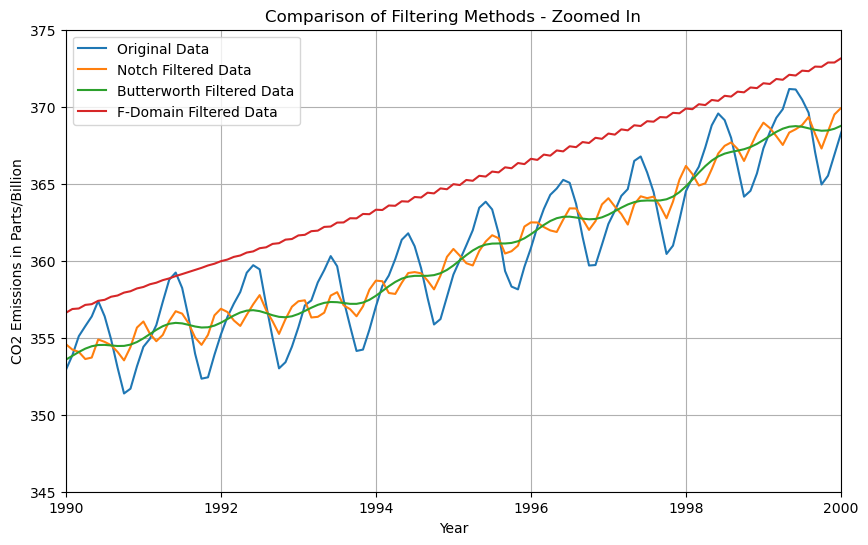

In [160]:
# Detrending the Data
coeff_raw, *_ = np.polyfit(years_array, co2_values_array, 1, full=True)

def linear_model(x, coefficients):
    return coefficients[0]*x + coefficients[1]

trend = linear_model(years_array, coeff_raw)
detrended_data = co2_values_array - trend # removing the trend

# Applying notch filter to the detrended data
# Define the notch filter parameters

fs = 12  # Sampling frequency
f0 = 1 # Frequency to be removed (annual oscillation)
Q = 30  # Quality factor

# Calculate the notch filter coefficients
b, a = iirnotch(f0, Q, fs)

# Apply the notch filter to the detrended data
notch_filtered_data = lfilter(b, a, detrended_data)

## Applying Butterworth Filter
# Define the cutoff frequency and filter order
cutoff_freq = 0.1
filter_order = 2

# Design the Butterworth low-pass filter
b, a = butter(filter_order, cutoff_freq, btype='low')

# Apply the filter to the data
butter_filtered_data = filtfilt(b, a, detrended_data)

# Plot the original detrended data and the filtered data
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(years_array, detrended_data, label='Detrended Data')
plt.plot(years_array, notch_filtered_data, label='Notch Filtered Detrended Data')
plt.plot(years_array, butter_filtered_data, label="Butterworth Filtered Data")
plt.title('Detrended Filtered CO2 Data')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions in Parts/Billion')
plt.legend()
plt.figure()

# Filtered Data w/ Trend Added Back
notch_w_trend = notch_filtered_data + trend
butter_w_trend = butter_filtered_data + trend

# Fourier Transforming the Detrended Data
dt = 1/12
detrended_data_fft = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(detrended_data))) * dt
f_axis = np.fft.fftshift(np.fft.fftfreq(len(detrended_data), dt))

# Plotting the Amplitude Spectrum
plt.figure(figsize=(10, 4))
plt.grid(True)
amplitude_spectrum = np.abs(detrended_data_fft)
plt.plot(f_axis, amplitude_spectrum)
plt.xlabel('Frequency (cycles/year)')
plt.ylabel('Amplitude')
plt.title('Amplitude Spectrum of Detrended CO2 Data')


# Plotting the Power Spectrum
plt.figure(figsize=(10, 4))
plt.grid(True)
power_spectrum = np.abs(detrended_data_fft)**2
plt.plot(f_axis, power_spectrum)
plt.xlabel('Frequency (cycles/year)')
plt.ylabel('Power')
plt.title('Power Spectrum of Detrended CO2 Data')


# Removing Annual Oscillation
detrended_data_fft_filtered = detrended_data_fft.copy()
detrended_data_fft_filtered[(np.abs(f_axis) > 0.9)] = 0

# Transform back to time domain
detrended_data_filtered = np.fft.ifft(detrended_data_fft_filtered).real
detrended_data_filtered += trend

## PART 4: PLOTTING 

plt.figure(figsize=(10, 6))
plt.plot(years_array, co2_values, label="Original Data")
plt.plot(years_array, notch_w_trend, label='Notch Filtered Data')
plt.plot(years_array, butter_w_trend, label="Butterworth Filtered Data")
plt.plot(years_array, detrended_data_filtered, label="F-Domain Filtered Data")
plt.title("Comparison of Filtering Methods")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions in Parts/Billion")
plt.legend()
plt.grid(True)

## PART 4: PLOTTING 
plt.figure(figsize=(10, 6))
plt.xlim(1990, 2000)
plt.ylim(345, 375)
plt.grid(True)
plt.plot(years_array, co2_values, label="Original Data")
plt.plot(years_array, notch_w_trend, label='Notch Filtered Data')
plt.plot(years_array, butter_w_trend, label="Butterworth Filtered Data")
plt.plot(years_array, detrended_data_filtered, label="F-Domain Filtered Data")
plt.title("Comparison of Filtering Methods - Zoomed In")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions in Parts/Billion")
plt.legend()

# Best fit
coeff_fft_filtered, *_ = np.polyfit(years_array, detrended_data_filtered, 1, full=True)
best_fit = linear_model(years_array, coeff_fft_filtered)
print(f"Line of Best Fit: y = {coeff_fft_filtered[0]}x {coeff_fft_filtered[1]}")


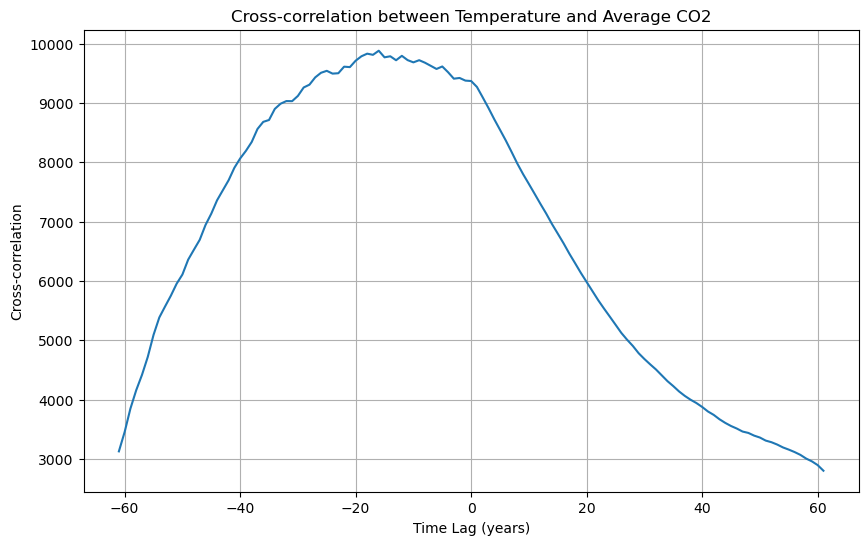

-16 9881.943969732036


In [134]:
# Pad arrays with zeros to ensure same length
N = len(temp)
temp_padded = np.pad(temp, (0, N - 1), mode='constant')
avg_values_padded = np.pad(avg_values, (0, N - 1), mode='constant')

# Compute FFT of padded arrays
temp_fft = np.fft.fft(temp_padded)
avg_co2_fft = np.fft.fft(avg_values_padded)[0:len(temp_fft)]

# Compute cross-correlation
correl_fft = np.fft.ifft(temp_fft.conj() * avg_co2_fft).real

# Shift and plot cross-correlation
x_axis = np.arange(-N + 1, N)
correl_fft_shifted = np.fft.fftshift(correl_fft)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, correl_fft_shifted)
plt.xlabel('Time Lag (years)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between Mean Annual Surface Temperature Change and Average CO2')
plt.grid(True)
plt.show()

max_index = np.argmax(correl_fft_shifted)
print(x_axis[max_index], correl_fft_shifted[max_index])

## Data Analysis

Overall, the results show a linearly-increasing trend of atmospheric CO2 over the past six decades, with atmospheric CO2 levels increasing by approximately 1.64 parts per billion each year according to the analysis. Furthermore, there appears to be a potential causal relationship with the mean annual surface temperature change. We proceed to describe the analysis:

- **Detrending the Data:** First, the data was detrended by fitting a linear trend to the CO2 concentration data to remove long-term patterns. The trend was subtracted from the raw data to obtain detrended version.
- **Notch Filtering:** Next, a notch filter was applied to remove annual oscillations from the detrended data, resulting in a graph similar to the raw data, but with damped oscillations, revealing a somewhat more precise trend.
- **Butterworth Filtering:** Following that, a different filter—a Butterworth low-pass filter—was applied to the detrended data, smoothing the annual oscillations significantly more than the notch filter, and retaining good alignment with the raw data (the peaks and troughs lined up well).
- **Fourier Transform and Spectrum Analysis:** Then, Fourier transform and spectrum analysis were performed on the detrended data to analyze frequency components. The amplitude spectrum of the detrended CO2 data was plotted, and annual oscillations were removed from the Fourier-transformed data by setting frequencies beyond 0.9 cycles per year to 0.
- **Comparison of Filtering Methods:** A comparison of different filtering methods was made by plotting the original CO2 data, notch-filtered data, Butterworth-filtered data, and F-domain filtered data. The best-fit line for the F-domain filtered data was determined seeing as it was linear.
- **Cross-correlation Analysis:** Finally, a cross-correlation analysis was conducted between CO2 concentrations and annual surface temperature data. The resulting plot displays a peak at -16 years, indicating a negative time lag, suggesting that the CO2 dataset leads the temperature dataset.

# Discussion

First, the concave shape observed in the detrended data suggests a non-linear pattern in the CO2 concentration over time, indicating fluctuating levels around the linear trend. Specifically, from 1960 to 1970, atmospheric CO2 levels were greater than the trend predicted by the linear model; from 1970 to 2010, they were below; and from 2010 onwards, they increased once more, surpassing the linear trend.

Moreover, the Fourier Transform of the detrended data has peaks at distinct frequencies. The peak at f=0 indicates the presence of a constant component in the data, while the peaks at f=±1 cycles/year represent an annual oscillation. Notably, there are also peaks at f=±2 cycles/year, indicating significant variations occurring twice a year, meaning there is a bi-annual pattern of CO2 levels. This suggests recurring fluctuations in the data, possibly linked to seasonal changes or other periodic phenomena happening bi-annually.

Comparing the filters, one can see that the notch-filtered data preserves fluctuations with a larger amplitude, indicating that it retains more of the high-frequency components in the original data. In contrast, the Butterworth-filtered data appears more damped or smoothed, suggesting a reduction in high-frequency noise and fluctuations. Despite this smoothing effect, the Butterworth-filtered data aligns closely with the overall trend of the raw data, indicating that it effectively removes noise while preserving the underlying trend. That said, the filtering using the Fourier Transform method provided the most effective removal of annual oscillations, but resulted in a trend that seems more linear than the true trend perhaps is (i.e., “overly-linear”). Regardless, valuable insights can still be gained from it; the equation of the line of the F-Domain filtered data is y = 1.64x - 2910 (rounded to three significant figures), indicating that, on average, atmospheric CO2 levels increase by approximately 1.64 parts per billion each year.

Finally, the cross-correlation analysis between atmospheric CO2 concentrations and temperature contains valuable insights. The peak correlation, reaching a value of 9881, occurs at a time lag of -16 years. This suggests that changes in CO2 levels precede temperature variations by about 16 years, implying a potential causal relationship between these two factors. Furthermore, the graph exhibits certain characteristics before versus after the zero time lag mark. From -60 to 0 years, the graph exhibits a convex shape, gradually ascending towards the peak. Conversely, beyond the zero mark, it transitions to a concave shape, with a steeper slope. This contributes to the fact that the negative time lag values on average have much higher correlation values as opposed to the positive time lag values, emphasizing the causal relationship between CO2 and surface temperature.

## Conclusion

In conclusion, atmospheric carbon dioxide seems to be increasing by approximately 1.64 parts per billion each year in a mostly linear fashion, albeit with deviations from this trend. Furthermore, the data analysis indicates a causal relationship between atmospheric carbon dioxide and mean surface temperature, where changes in CO2 precede corresponding changes in temperature by about 16 years.

## References

1. International Monetary Fund. (2022) Climate Change Indicators Dashboard. [World Monthly Atmospheric Carbon Dioxide Concentrations](https://climatedata.imf.org/pages/access-data). (Accessed: 15 April 2024)
2. International Monetary Fund. (2022) Climate Change Indicators Dashboard. [Annual Surface Temperature Change](https://climatedata.imf.org/pages/access-data). (Accessed: 15 April 2024)
3. Lindsey, R. (2024) Climate change: Atmospheric carbon dioxide, NOAA Climate.gov. Available at: https://www.climate.gov/news-features/understanding-climate/climate-change-atmospheric-carbon-dioxide#:~:text=Without%20carbon%20dioxide%2C%20Earth’s%20natural,causing%20global%20temperature%20to%20rise. (Accessed: 20 April 2024). 
4. Means, T. (2023) Climate change and droughts: What’s the connection? " Yale climate connections, Yale Climate Connections. Available at: https://yaleclimateconnections.org/2023/05/climate-change-and-droughts-whats-the-connection/ (Accessed: 20 April 2024). 